In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import glob
import cv2
from sklearn.model_selection import train_test_split


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
x = np.load('/kaggle/input/pattern-data/data_processed.npy')
y = np.load('/kaggle/input/pattern-data/labels.npy')


def preprocess_images(img , lower = 22 , higher = 202 , blur = 5):
    
    denoised = cv2.fastNlMeansDenoising(img, h=10, templateWindowSize=7, searchWindowSize=21)

    for _ in range(blur):
        denoised = cv2.GaussianBlur(denoised,(5,5),0)

    
    lower = np.array([lower])
    upper = np.array([higher])

    mask = cv2.inRange(denoised, lower, upper)
    denoised = cv2.bitwise_and(denoised, denoised, mask=mask)
    target_size = (200,1440//2)
    resized_image = cv2.resize(denoised, target_size)

    return resized_image

In [ ]:
from tqdm import tqdm

x_processed = []
for img in tqdm(x):
    img_p = preprocess_images(img)
    x_processed.append(img_p)
    
    
x_p = np.array(x_processed)

In [3]:
from sklearn.utils import shuffle
import numpy as np


X2, Y2 = shuffle(x_p, y, random_state=30)


In [4]:
for _ in range(7):
    X2, Y2 = shuffle(X2, Y2, random_state=20)



In [5]:
labels = np.array([1 if i >= Y2.mean() else 0 for i in Y2])


In [7]:
X2[0].shape

(1440, 400)

In [8]:
x_train , x_test , y_train , y_test = train_test_split(X2,labels,random_state = 77 , test_size = 0.2)

In [9]:
my_strategy = tf.distribute.MirroredStrategy()
with my_strategy.scope():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(1440 , 400 , 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))

    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1 , activation = 'sigmoid')) 

    model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy()   ) 

    hist = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.15)

Epoch 1/10
24/24 [==============================] - 23s 616ms/step - loss: 0.6413 - val_loss: 0.2936
Epoch 2/10
24/24 [==============================] - 10s 430ms/step - loss: 0.3271 - val_loss: 0.1914
Epoch 3/10
24/24 [==============================] - 11s 443ms/step - loss: 0.1781 - val_loss: 0.1678
Epoch 4/10
24/24 [==============================] - 10s 426ms/step - loss: 0.1143 - val_loss: 0.1256
Epoch 5/10
24/24 [==============================] - 11s 440ms/step - loss: 0.0616 - val_loss: 0.1512
Epoch 6/10
24/24 [==============================] - 10s 422ms/step - loss: 0.0260 - val_loss: 0.1273
Epoch 7/10
24/24 [==============================] - 10s 423ms/step - loss: 0.0065 - val_loss: 0.1284
Epoch 8/10
24/24 [==============================] - 11s 442ms/step - loss: 0.0011 - val_loss: 0.1338
Epoch 9/10
24/24 [==============================] - 11s 454ms/step - loss: 8.8820e-04 - val_loss: 0.1370
Epoch 10/10
24/24 [==============================] - 11s 440ms/step - loss: 4.5803e-04 

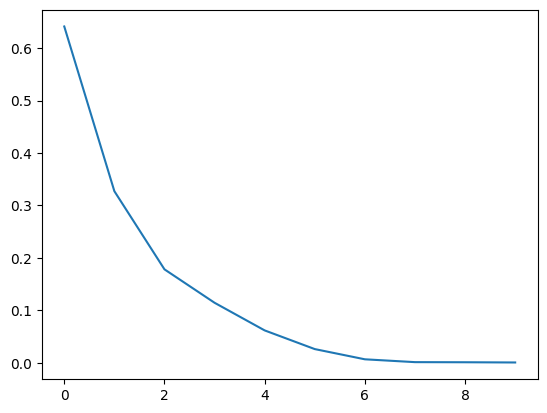

In [23]:
plt.plot(hist.history['loss'])

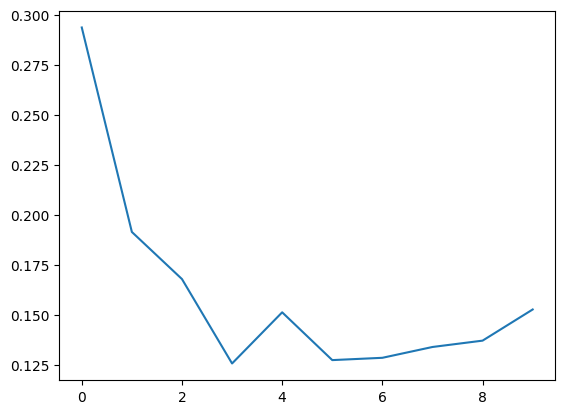

In [24]:
plt.plot(hist.history['val_loss'])

In [35]:
preds = model.predict(x_test)
t = 0.50
preds_b = [1 if i >= t else 0 for i in preds]

from sklearn.metrics import accuracy_score
score = accuracy_score(y_test , preds_b)

7/7 [==============================] - 1s 98ms/step


In [36]:
score

0.9641255605381166